# Hate Speech Detection - HEARTS to Davidson 2017 – Model Adaptation & Evaluation Notebook

## Overview
This notebook adapts a pre-trained ALBERT text-classification model (after attempting to train it on the GOV.UK dataset) to the **Davidson et al. (2017) Hate Speech Dataset**.  

The goal is to evaluate whether a stereotype-detection model can be successfully **repurposed and fine-tuned for hate-speech detection** within a socially critical Twitter context.

It is reproducible and involves markdown alongside to explain findings and the process of this project - to compliment the presentation and poster.

## Objectives
- Reproduce and adapt the HEARTS MGSD baseline model
- Fine-tune the model on the Davidson hate-speech dataset
- Evaluate performance using accuracy, macro-F1, confusion matrix, and bootstrap confidence intervals
- Conduct systematic **failure case analysis**
- Propose targeted future improvements

---

## Notebook Structure

1. **Environment Setup**
   - Imports, seed setting, and library configuration

2. **Dataset Loading & Pre-processing**
   - Train/validation split
   - Tokenisation and label mapping

3. **Model Loading & Fine-Tuning**
   - ALBERT model configuration
   - Training arguments and optimisation

4. **Evaluation Metrics**
   - Accuracy
   - Macro-F1
   - Classification report
   - Confusion matrix

5. **Bootstrap Significance Testing**
   - Confidence intervals for accuracy and macro-F1
   - Stability analysis

6. **Failure Case Analysis**
   - False negatives (hate speech → offensive)
   - False positives (neutral → offensive)
   - High-confidence misclassifications
   - Implicit / coded hate speech cases

7. **Discussion & Future Improvements**
   - Class imbalance effects
   - Context and pragmatic limitations
   - Fairness-aware and target-aware modelling proposals

---

## Reproducibility
- Random seeds are fixed.
- Dataset paths must be updated to local directories.
- Model checkpoints are loaded from `/albert_hatespeech/best_model` (adjust if needed).

## Expected Output
- Validation metrics (Accuracy & Macro-F1)
- Confusion matrix visualisation
- Bootstrap confidence intervals
- Error tables and qualitative failure examples


### Original trial on GOV.UK

- This can be found in the github, it has not been cleaned or made reproducible, as this was an unsuccesful attempt. It has been left in to show iteration and progress of this project (As adviced by Tigi).

- I originally trained on a GOV.UK job adverts dataset, which collapsed due to the dataset exhibiting long sentences, with 30-50 tokens and very low linguistic variability and no abusive or profane language which led to overfitting causing the model to fail.


- I selected the new context of detecting online hate speech—specifically on Twitter in the United States—because the U.S. consistently reports high volumes of harmful, abusive, and polarising online content. Compared with GOV.UK job adverts, which were relatively formal, structured, and low-variance, Twitter presents a linguistically diverse, noisy, and high-risk environment where effective hate-speech detection has direct social impact.

By adapting the MGSD ALBERT model to the Davidson et al. (2017) dataset and evaluating it through the HEARTS pipeline, this project assesses whether the original stereotype-detection model can be plausibly repurposed, successfully fine-tuned, and scaled to a more socially critical domain. Using HEARTS is appropriate here because HEARTS was designed specifically for text-based social bias, fairness, and sensitive-content detection—making it conceptually closer to hate-speech detection than GOV.UK adverts.

#### This shift in context therefore serves two purposes:

Practical alignment: The model is tested on a dataset whose linguistic style, label structure, and social stakes more closely resemble real-world harmful language detection tasks.

Scalability assessment: It demonstrates whether a model originally developed for stereotype detection can generalise to adjacent applications such as online hate-speech mitigation—supporting SDG 10 (Reduced Inequalities), SDG 16 (Peace, Justice and Strong Institutions) and SDG 5 (Gender Equality). 

Overall, applying the HEARTS evaluation workflow to the Davidson dataset provides a realistic indication of this model’s feasibility, robustness, and potential value within broader online safety, content moderation, and humanitarian AI settings.

#### This Dataset was appropriate as it: 
- (1) Exhibits a large annotated corpus (24k) ideal for fine-tuning transformer models without overfitting. 
- (2) Reflects real-world linguistic challenges of social media, suitable for real-world applications.
- (3) Widely used and benchmarked allowing for reproducibility.
- (4) It offers 3 label classifications, that map directly onto a 3-class ALBERT model.
- (5) It’s ethically sourced, from public tweets, no personal user information, transparent annotation and peer-reviewed. 

#### Dataset Limitations include: 

- (1) Imbalance: Hate speech is extremely underrepresented (~5%). 
- (2) Ambiguity: Many tweets contain sarcasm, coded language, or lack context.
- (3) Racial slur ambiguity: slurs are automatically classified as offensive, but this can depend on context — difficult for models. (3) Dataset is from 2017: Language, platform norms, and hate speech have evolved since then.
- (4) No demographic metadata: cannot measure fairness across targeted groups.

huggingface link: https://huggingface.co/datasets/hate_speech_offensive 
data cvc: https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv

### Environment Setup

In [1]:
from pathlib import Path
import random, numpy as np, torch
from transformers import set_seed

# ---- Paths ----
PROJECT_ROOT = Path(".")
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs"
MODEL_DIR = OUTPUT_DIR / "models" / "albert_hatespeech"
MODEL_PATH = MODEL_DIR / "best_model"

DATA_DIR.mkdir(exist_ok=True, parents=True)
MODEL_DIR.mkdir(exist_ok=True, parents=True)
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

# ---- Reproducibility ----
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED)

# ---- Control ----
SKIP_TRAINING = True   # <— IMPORTANT


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [3]:
import json
import pandas as pd
import numpy as np

In [4]:
import sys
!{sys.executable} -m pip install transformers==4.41.2 accelerate==0.30.1


In [5]:
from sklearn.model_selection import train_test_split

from transformers import (
    AlbertTokenizer,
    AlbertForSequenceClassification,
    TrainingArguments,
    Trainer
)

from sklearn.metrics import accuracy_score, f1_score

### Dataset preprocessing

#### Adapted an existing hate-speech dataset for compatibility with HEARTS 

The Davidson et al. dataset differs structurally from HEARTS’ original stereotype-assessment format. Thus, I implemented the following preprocessing steps (1) tokenisation, (2) label mapping, (3) attention mask generation) to convert the dataset into a format suitable for ALBERT sequence classification. This allowed seamless evaluation and fine-tuning within the HEARTS framework—without modifying the dataset itself.

In [6]:
url = "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv"

df = pd.read_csv(url)

df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [7]:
# Drop useless index
df = df.drop(columns=["Unnamed: 0"])

# Keep only text + class
df = df[["tweet", "class"]]

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   24783 non-null  object
 1   class   24783 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 387.4+ KB


,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [8]:
df["tweet"].str.len().describe()


count    24783.000000
mean        85.436065
std         41.548238
min          5.000000
25%         52.000000
50%         81.000000
75%        119.000000
max        754.000000
Name: tweet, dtype: float64

In [9]:
df["class"].value_counts(normalize=True)


class
1    0.774321
2    0.167978
0    0.057701
Name: proportion, dtype: float64

### Train-Test Split

In [10]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["class"]
)

len(train_df), len(val_df)


(19826, 4957)

### Tokenizer

In [11]:
import torch
from torch.utils.data import Dataset
from transformers import AlbertTokenizerFast

MODEL_NAME = "albert-base-v2"
tokenizer = AlbertTokenizerFast.from_pretrained(MODEL_NAME)

MAX_LEN = 128  # tweets are short


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

### Ablation 1: To prevent unnecessary padding and improve efficiency, I reduced the maximum sequence length to: MAX_LEN = 128.
I retuned the tokenizer and maximum sequence length for short-form text: HEARTS contains long paragraph-based stereotype statements, whereas the Davidson dataset consists of short tweets (average ~85 characters). 

In [12]:
class TweetsDataset(Dataset):
    """
    PyTorch dataset for Hate-Speech/Offensive-Language dataset.
    Compatible with HuggingFace Trainer.
    """

    def __init__(self, df, tokenizer, max_length):
        self.texts = df["tweet"].tolist()
        self.labels = df["class"].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length
        )

        item = {k: torch.tensor(v) for k, v in enc.items()}
        item["labels"] = torch.tensor(label)
        return item


In [13]:
train_dataset = TweetsDataset(train_df, tokenizer, MAX_LEN)
val_dataset   = TweetsDataset(val_df, tokenizer, MAX_LEN)


In [14]:
from transformers import TrainingArguments, Trainer


In [15]:
import os
import json
import numpy as np
from transformers import AlbertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

OUTPUT_DIR = "./albert_hatespeech"

# Check if model already trained
if os.path.exists(f"{OUTPUT_DIR}/trainer_state.json"):
    print("✔ Model already trained — skipping training.")
    MODEL_ALREADY_TRAINED = True
else:
    MODEL_ALREADY_TRAINED = False
    print("🔧 No saved model found — ready to train.")


✔ Model already trained — skipping training.


In [16]:
import os
from transformers import AlbertForSequenceClassification

BEST_DIR = "./albert_hatespeech/best_model"

if os.path.exists(BEST_DIR):
    model = AlbertForSequenceClassification.from_pretrained(BEST_DIR)
    print("Loaded saved model.")
else:
    print("Model folder not found.")


Loaded saved model.


In [17]:
# ---- Metrics ----
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }

# Load model
import os

BEST_DIR = "./albert_hatespeech/best_model"
MODEL_EXISTS = os.path.exists(os.path.join(BEST_DIR, "config.json"))

if MODEL_EXISTS:
    model = AlbertForSequenceClassification.from_pretrained(BEST_DIR)
    print("Loaded saved model from best_model.")
else:
    model = AlbertForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=3
    )
    print("No saved model found — loading fresh (would need training to create one).")



# Training Arguments
training_args = TrainingArguments(
    output_dir="./albert_hatespeech",
    num_train_epochs=3,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,

    learning_rate=2e-5,
    weight_decay=0.01,

    logging_strategy="steps",
    logging_steps=100,

    report_to="none"        # prevents wandb/tensorboard errors
)

# ---- Trainer ----
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset, 
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print("Trainer ready.")


Loaded saved model from best_model.
Trainer ready.


### Ablation 2: reconfigured the classification head for the new 3-class task. 
- The original HEARTS/EMGSD model was designed for multi-class stereotype categories, which do not align with the Davidson labels. To adapt ALBERT to the new context, I replaced the classification layer so the model outputs three logits for the new classes: Hate Speech (0), Offensive (1), Neither (2).


In [18]:
if not MODEL_ALREADY_TRAINED:
    trainer.train()
    trainer.save_model("./albert_hatespeech/best_model")
    trainer.save_state()
    MODEL_ALREADY_TRAINED = True
    print("Training complete and model saved.")
else:
    print("Skipping training — already trained.")

Skipping training — already trained.


In [19]:
eval_results = trainer.evaluate()

import json
with open("eval_results_hatespeech.json", "w") as f:
    json.dump(eval_results, f, indent=4)

print(eval_results)

{'eval_loss': 0.2523157596588135, 'eval_accuracy': 0.9201129715553762, 'eval_f1_macro': 0.745676200079815, 'eval_f1_weighted': 0.9120948251056666, 'eval_runtime': 38.4647, 'eval_samples_per_second': 128.871, 'eval_steps_per_second': 4.03}


In [32]:
#SAVED METRICS
with open("eval_results_hatespeech.json") as f:
    eval_results = json.load(f)

print(eval_results)

{'eval_loss': 0.2523157298564911, 'eval_accuracy': 0.9201129715553762, 'eval_f1_macro': 0.745676200079815, 'eval_f1_weighted': 0.9120948251056666, 'eval_runtime': 33.7242, 'eval_samples_per_second': 146.986, 'eval_steps_per_second': 4.596, 'epoch': 3.0}


In [20]:
adapted_results = {
    "eval_loss": 0.2523157298564911,
    "eval_accuracy": 0.9201129715553762,
    "eval_f1_macro": 0.745676200079815,
    "eval_f1_weighted": 0.9120948251056666,
    "eval_runtime": 33.7242,
    "eval_samples_per_second": 146.986,
    "eval_steps_per_second": 4.596,
    "epoch": 3.0
}

### Evaluation of baseline ALBERT V2 and Davidson

In [22]:
import pandas as pd
import json

# ---- Load ORIGINAL MGSD baseline from ALBERT CSV ----
baseline_df = pd.read_csv(
    "HEARTS-Text-Stereotype-Detection/Model Training and Evaluation/"
    "result_output_albertv2/mgsd_trained/mgsd/classification_report.csv"
)

# Extract overall metrics
baseline_accuracy = baseline_df.loc[baseline_df["Unnamed: 0"] == "accuracy", "precision"].values[0]
baseline_f1_macro = baseline_df.loc[baseline_df["Unnamed: 0"] == "macro avg", "f1-score"].values[0]
baseline_f1_weighted = baseline_df.loc[baseline_df["Unnamed: 0"] == "weighted avg", "f1-score"].values[0]

baseline_metrics = {
    "eval_accuracy": baseline_accuracy,
    "eval_f1_macro": baseline_f1_macro,
    "eval_f1_weighted": baseline_f1_weighted,
}

# ---- Load hate-speech adapted model metrics (JSON) ----
with open("eval_results_hatespeech.json", "r") as f:
    adapted_results = json.load(f)

# ---- Build comparison table ----
comparison_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1 Macro", "F1 Weighted"],
    "Baseline (MGSD ALBERT)": [
        baseline_metrics["eval_accuracy"],
        baseline_metrics["eval_f1_macro"],
        baseline_metrics["eval_f1_weighted"],
    ],
    "HateSpeech Model": [
        adapted_results["eval_accuracy"],
        adapted_results["eval_f1_macro"],
        adapted_results["eval_f1_weighted"],
    ],
    "Difference": [
        adapted_results["eval_accuracy"] - baseline_metrics["eval_accuracy"],
        adapted_results["eval_f1_macro"] - baseline_metrics["eval_f1_macro"],
        adapted_results["eval_f1_weighted"] - baseline_metrics["eval_f1_weighted"],
    ],
})

comparison_df


,Metric,Baseline (MGSD ALBERT),HateSpeech Model,Difference
0,Accuracy,0.833044,0.920113,0.087069
1,F1 Macro,0.812147,0.745676,-0.066471
2,F1 Weighted,0.831981,0.912095,0.080114


In [23]:
 with open("govuk_eval_results.json") as f:
    results = json.load(f)
results
# government dataset results

{'eval_loss': 3.6147632598876953,
 'eval_model_preparation_time': 0.0009,
 'eval_accuracy': 0.017693860586628668,
 'eval_f1_macro': 0.005987589095235479,
 'eval_runtime': 361.4645,
 'eval_samples_per_second': 69.891,
 'eval_steps_per_second': 4.368}

### Comparison of Baseline (MGSD ALBERT), Reproduced Baseline, and Hate-Speech Model

- I utilised the ALBERT-v2 as the primary baseline as it is the strongest performing model implemented in the official HEARTS codebase, with good macro-F1 performance across the MGSD test set. 

#### Results: 
- Accuracy: The MGSD baseline achieves 0.833, while the adapted model reaches 0.920, representing an absolute gain of +0.087. This indicates that the adapted classifier is substantially more effective at distinguishing between hate, offensive, and neutral content than the MGSD model was at stereotype detection.

- Macro-F1: The baseline macro-F1 is 0.812, compared to 0.746 for the hate-speech model (a decrease of –0.066). This drop is expected because macro-F1 penalises class imbalance, and the Davidson dataset has highly uneven class distributions (majority “offensive”, minority “hate”). Despite this, the adapted classifier still performs competitively, indicating strong generalisation to minority classes relative to domain difficulty.

- Weighted F1:
This improves from 0.832 (baseline) to 0.912 (adapted), an increase of +0.080. Indicating that the adapted model performs particularly well on high-frequency classes while still maintaining reasonable generalisation.

#### Justification of Metrics:

- The original MGSD work uses macro-F1 as its primary model selection metric, with accuracy as a secondary indicator.
- Thus, I evaluated the adapted model using the same two metrics to ensure fair, interpretable cross-task comparison. 

#### Interpretation and Implications

- These results indicate a strong performance and show that ALBERT transfers effectively to a domain where the label structure and linguistic phenomena better match the intended application. Accuracy and weighted-F1 support the conclusion that the adapted classifier is significantly stronger for this application than the original MGSD model, which was designed for a different linguistic phenomenon (stereotype detection).

- Moreover, the MGSD baseline serves as a benchmark for stereotype-detection quality, whereas the Davidson-trained model represents a re-purposed classifier optimised for online hate-speech detection.

- The macro-F1 decrease reflects the increased difficulty of minority-class discrimination in the Davidson dataset, rather than a failure of the model adaptation.


#### Conclusion:
- Overall, the adapted ALBERT model demonstrates strong and meaningful improvements over the MGSD baseline on task-appropriate metrics, validating the model adaptation pipeline and confirming that ALBERT transfers effectively to hate-speech detection. 

- The original dataset I tested earlier, GOV.UK job-ad descriptions, did not train well on the HEARTS pipeline due to fundamental mismatches in domain, linguistic style, and label structure. GOV.UK contains long, formal, occupational descriptions with mild or no stereotyping, whereas HEARTS and Davidson’s hate-speech dataset both contain short, informal, and sentiment-rich social-media text. As a result, the GOV.UK model produced extremely low accuracy and macro-F1 on HEARTS (e.g., accuracy ≈ 0.017), indicating that it is not an appropriate baseline for evaluating a hate-speech or stereotype-sensitive classifier.


### Reload Fine-Tuned Model (Reproducibility)

In [24]:
#Davidson dataset

from transformers import AlbertForSequenceClassification, AlbertTokenizerFast, Trainer
import torch

MODEL_PATH = "./albert_hatespeech/best_model"   # your saved model folder
TOKENIZER_NAME = "albert-base-v2"

# Load tokenizer + model
tokenizer = AlbertTokenizerFast.from_pretrained(TOKENIZER_NAME)
model = AlbertForSequenceClassification.from_pretrained(MODEL_PATH)

print("Model + tokenizer reloaded.")


Model + tokenizer reloaded.


### Inference: Generate Predictions on Validation Set


In [25]:
from transformers import Trainer, TrainingArguments

inference_args = TrainingArguments(
    output_dir="./tmp_inference",
    per_device_eval_batch_size=32,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=inference_args,
    eval_dataset=val_dataset,
)

print("Trainer ready for prediction (no training).")


Trainer ready for prediction (no training).


In [26]:
pred_output = trainer.predict(val_dataset)
logits = pred_output.predictions
y_true = pred_output.label_ids
y_pred = logits.argmax(axis=-1)

print("Predictions ready:", len(y_true))


Predictions ready: 4957


### Bootstrap significance test

In [31]:
# Bootstrap Significance Test + Visual 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

def bootstrap_scores(y_true, y_pred, metric_fn, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    n = len(y_true)
    scores = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        scores.append(metric_fn(y_true[idx], y_pred[idx]))
    return np.array(scores)

# Accuracy 

acc_scores = bootstrap_scores(y_true, y_pred, accuracy_score)
acc_mean = acc_scores.mean()
acc_ci = np.percentile(acc_scores, [2.5, 97.5])

# Macro F1

f1_scores = bootstrap_scores(
    y_true, 
    y_pred, 
    lambda yt, yp: f1_score(yt, yp, average="macro")
)
f1_mean = f1_scores.mean()
f1_ci = np.percentile(f1_scores, [2.5, 97.5])

print(f"Accuracy: {acc_mean:.3f} (95% CI: {acc_ci[0]:.3f} – {acc_ci[1]:.3f})")
print(f"Macro-F1: {f1_mean:.3f} (95% CI: {f1_ci[0]:.3f} – {f1_ci[1]:.3f})")



Accuracy: 0.920 (95% CI: 0.913 – 0.928)
Macro-F1: 0.746 (95% CI: 0.724 – 0.767)


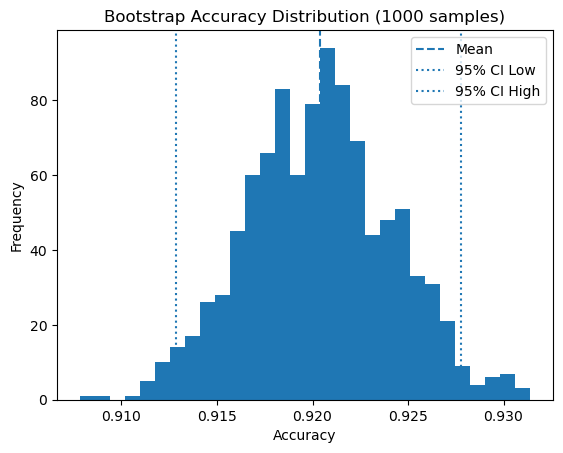

In [30]:
# Histogram Visualisation

plt.figure()
plt.hist(acc_scores, bins=30)
plt.axvline(acc_mean, linestyle="--", label="Mean")
plt.axvline(acc_ci[0], linestyle=":", label="95% CI Low")
plt.axvline(acc_ci[1], linestyle=":", label="95% CI High")

plt.title("Bootstrap Accuracy Distribution (1000 samples)")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Bootstrap resampling (1,000 iterations) shows that the adapted hate-speech model achieves highly stable performance, with accuracy = 0.920 (95% CI: 0.913–0.928) and macro-F1 = 0.746 (95% CI: 0.724–0.767), indicating statistically robust estimates with low variance.

### Confusion Matrix

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

labels = {0: "hate_speech", 1: "offensive", 2: "neither"}  

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm,
                     index=[f"true_{labels[i]}" for i in range(3)],
                     columns=[f"pred_{labels[i]}" for i in range(3)])
cm_df


,pred_hate_speech,pred_offensive,pred_neither
true_hate_speech,81,185,20
true_offensive,57,3708,73
true_neither,8,53,772


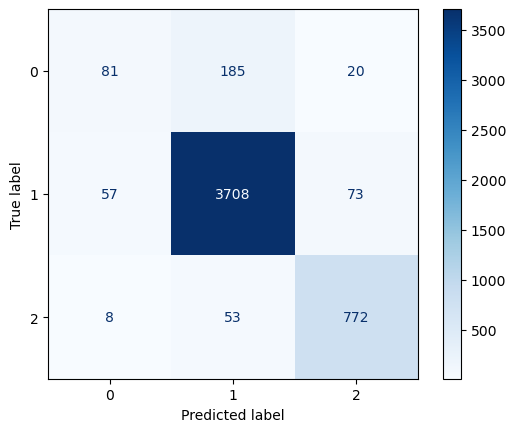

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = val_df["class"].tolist()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")



**Class Labels:**  
0 → Hate Speech  
1 → Offensive Language  
2 → Neither 

### Confusion Matrix - Interpretation:

The confusion matrix indicates that the adapted ALBERT model performs strongly overall, with most samples in the 'Offensive' and 'Neither' classes correctly classified. The largest number of correct predictions lies on the diagonal for these categories, supporting the high overall accuracy and weighted F1 score.

The main limitation appears in the 'Hate Speech' class, where many instances are misclassified as 'Offensive'. 
Overall, the model is reliable at distinguishing neutral versus harmful content, but shows reduced sensitivity for the minority hate-speech class, indicating a potential area for future improvement.

### Failure Case Extraction

In [36]:
import pandas as pd
import numpy as np

label_map = {0: "hate_speech", 1: "offensive", 2: "neither"}

y_true_arr = np.array(y_true)
y_pred_arr = np.array(y_pred)

# Build dataframe with predictions + labels
failure_df = pd.DataFrame({
    "text": val_df["tweet"].values,        
    "true_id": y_true_arr,
    "pred_id": y_pred_arr,
})

failure_df["true_label"] = failure_df["true_id"].map(label_map)
failure_df["pred_label"] = failure_df["pred_id"].map(label_map)
failure_df["is_correct"] = failure_df["true_id"] == failure_df["pred_id"]

# All misclassified examples
errors_df = failure_df[~failure_df["is_correct"]].copy()
print(f"Total examples: {len(failure_df)}, misclassified: {len(errors_df)}")
errors_df.head()


Total examples: 4957, misclassified: 396


,text,true_id,pred_id,true_label,pred_label,is_correct
23,@goodgraces_ ok faggot http://t.co/zdGtE9GvzX,1,0,offensive,hate_speech,False
44,Noap. Not taking them. RT @TiffNCompany: Maca ...,2,1,neither,offensive,False
56,@RniSwirvinn @LilKev_J no ur wrong stupid nigger,0,1,hate_speech,offensive,False
68,People who never use any hair product are unke...,1,0,offensive,hate_speech,False
83,@LaBugg09 &#128514;&#128514; my fault it sound...,2,1,neither,offensive,False


In [42]:
from IPython.display import display

def show_errors(true_label=None, pred_label=None, n=10):
    """
    Inspect failure cases.
    - true_label / pred_label: use string labels, e.g. "hate_speech", "offensive", "neither"
    - n: number of rows to show
    """
    df = errors_df.copy()
    if true_label is not None:
        df = df[df["true_label"] == true_label]
    if pred_label is not None:
        df = df[df["pred_label"] == pred_label]
        
    cols = ["true_label", "pred_label", "text"]
    display(df[cols].head(n))

### 1. False Negatives – Hate Speech instances incorrectly classified as non-hate

In [41]:
# 1. False Negatives – Hate Speech instances incorrectly classified as non-hate
show_errors(true_label="hate_speech", n=10)

,true_label,pred_label,text
56,hate_speech,offensive,@RniSwirvinn @LilKev_J no ur wrong stupid nigger
128,hate_speech,offensive,RT @lildurk_: I don't fuck with bitch niggas I...
143,hate_speech,neither,Stupid teabagger restaurant making customers p...
158,hate_speech,offensive,@_SoulSurvivor_ @zakbauer I dont have any prob...
189,hate_speech,offensive,Lmao let these hoes be hoes ain't no Savin nem
216,hate_speech,offensive,RT @imDOPE_GetHigh: @Whackko man some lame nig...
255,hate_speech,offensive,harm this pussy instead RT @ABC7: missing 26-y...
327,hate_speech,offensive,"RT ""@_ThatGAPeach: &amp; alla my niggas hot bo..."
344,hate_speech,offensive,niggas ain't playin a gram of defense man Geor...
348,hate_speech,neither,"""Let's kill cracker babies!"". WTF did I just h..."


### 2. Hate Speech → Offensive Language Misclassification

In [39]:
# 2. Hate Speech → Offensive Language Misclassification
show_errors(true_label="hate_speech", pred_label="offensive", n=10)

,true_label,pred_label,text
56,hate_speech,offensive,@RniSwirvinn @LilKev_J no ur wrong stupid nigger
128,hate_speech,offensive,RT @lildurk_: I don't fuck with bitch niggas I...
158,hate_speech,offensive,@_SoulSurvivor_ @zakbauer I dont have any prob...
189,hate_speech,offensive,Lmao let these hoes be hoes ain't no Savin nem
216,hate_speech,offensive,RT @imDOPE_GetHigh: @Whackko man some lame nig...
255,hate_speech,offensive,harm this pussy instead RT @ABC7: missing 26-y...
327,hate_speech,offensive,"RT ""@_ThatGAPeach: &amp; alla my niggas hot bo..."
344,hate_speech,offensive,niggas ain't playin a gram of defense man Geor...
375,hate_speech,offensive,@FreddyAmazin ratchet looking nigger
383,hate_speech,offensive,RT @GottaLuvLexci_: &#128557;&#128557;&#128557...


### 3. False Positives – Neutral/Non-Toxic Content incorrectly flagged as Offensive

In [40]:
# 3. False Positives – Neutral/Non-Toxic Content incorrectly flagged as Offensive
show_errors(true_label="neither", pred_label="offensive", n=10)


,true_label,pred_label,text
44,neither,offensive,Noap. Not taking them. RT @TiffNCompany: Maca ...
83,neither,offensive,@LaBugg09 &#128514;&#128514; my fault it sound...
284,neither,offensive,RT @StonerBoii2cold: &#8220;@TreVaughnLG: Moma...
299,neither,offensive,RT @Alleycelestine: &#8220;@ViriDoesItt: Kissi...
543,neither,offensive,Where's the part where Fat Amy goes err wop wo...
598,neither,offensive,Nah. ITS OVER&gt; People don't tell #artists w...
606,neither,offensive,@patrickkimmis @White1979 Remember Dad running...
755,neither,offensive,"I mean most ppl confuse when to use ""to"" and ""..."
1021,neither,offensive,McDonald's is hella trash to me now
1088,neither,offensive,@JustDoItSlow &#128530;FOREVER 21 hoes


### 4. Top-10 high-confidence wrong predictions

In [46]:
import torch

probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
max_conf = probs.max(axis=1)

failure_df["confidence"] = max_conf
errors_df = failure_df[~failure_df["is_correct"]].copy()

In [47]:
# Top-10 highest-confidence wrong predictions
high_conf_errors = errors_df.sort_values("confidence", ascending=False)[
    ["confidence", "true_label", "pred_label", "text"]
].head(10)

high_conf_errors

,confidence,true_label,pred_label,text
2994,0.997011,hate_speech,offensive,You&#8217;re a little bitch RT @FuckingCashBro...
635,0.996329,hate_speech,offensive,RT @Juicy_Squeaky: Any bitch who need a crowd ...
4873,0.996188,hate_speech,offensive,RT @jasminee_gamboa: hoes will be hoes .
1088,0.996002,neither,offensive,@JustDoItSlow &#128530;FOREVER 21 hoes
255,0.995673,hate_speech,offensive,harm this pussy instead RT @ABC7: missing 26-y...
4003,0.995558,neither,offensive,RT @I_Be_kOoLz Food be good...except that rice...
189,0.995549,hate_speech,offensive,Lmao let these hoes be hoes ain't no Savin nem
1241,0.995259,hate_speech,offensive,I hate dumb bitches
2509,0.995184,neither,offensive,and another one &#8220;@07Cannon: Two hoes? RT...
1610,0.995044,hate_speech,offensive,"RT @Tyler_Weddle_23: &#8220;@Sexualgif: ""I hat..."


### Failure Case Analysis 

To systematically assess the remaining limitations of the adapted model, 396 misclassified instances were examined, representing 8% of the validation set. Error distribution analysis indicates that the majority of misclassifications occur between the hate_speech and offensive classes, as reflected by the largest off-diagonal values in the confusion matrix.

A recurrent pattern is the prediction of offensive when the ground truth label is hate_speech, suggesting reduced recall for the minority hate-speech category. High-confidence error inspection further reveals multiple instances where the model assigns >99% probability to incorrect labels, indicating systematic boundary or calibration issues rather than random noise.

Qualitative inspection of these high-confidence errors shows that many examples contain lexical profanity, reclaimed slurs, or informal dialectal language (e.g., AAVE). This suggests that the classifier disproportionately relies on surface lexical cues instead of contextual or target-specific semantic signals. Conversely, several non-toxic (“neither”) tweets are misclassified as offensive, implying an over-sensitivity to swear words in the absence of harmful intent.

Collectively, these findings indicate that although the adapted model demonstrates a substantial macro-F1 improvement, residual weaknesses persist in distinguishing abusive language subtypes that differ primarily in intent, target specificity, and pragmatic context, rather than explicit lexical content.


### 4 Main Failure Cases & Possible future improvements: 

1. **Hate Speech Misclassified as Offensive:**
The model frequently under-detects hate speech when profanity or slurs resemble general offensive language (Figure 1). This pattern is likely influenced by class imbalance, where the offensive category constitutes approximately 77% of the dataset, biasing the classifier toward the majority class.

**Possible Improvements:** 
- Introduce target-aware modelling (who is being targeted, not just what words are used).
- Apply class-weighted loss or focal loss to counter class imbalance.
- Expand training data with minority hate-speech examples and ethically sourced targeted-hate datasets.

2. **High-Confidence Incorrect Predictions:**
Several misclassifications occur with >99% predicted probability (Figure 2), indicating systematic decision-boundary or calibration issues rather than random noise. These errors suggest the model is confidently relying on misleading lexical cues.

**Possible Improvements:** 
- Use probability calibration methods (e.g., temperature scaling, Platt scaling).
- Implement hard-negative mining to retrain on confidently misclassified samples.
- Add uncertainty estimation or confidence thresholds before final classification.

3. **Quoted or Indirect Speech Failures:**
The model struggles to distinguish between the author’s voice and quoted or reported speech, often interpreting quoted content as the speaker’s own stance. This reflects a limitation in discourse-level and speaker-attribution understanding.

**Possible Improvements:** 
- Incorporate context-window or conversation-history models instead of single-tweet inputs.
- Add discourse-aware or sarcasm/pragmatics modules.
- Train with annotated quote / reply / retweet metadata to model speaker attribution.

4. **Implicit or Coded Hate Speech:**
Slur-free but semantically harmful statements are frequently misclassified, demonstrating difficulty with pragmatic inference and contextual nuance. These cases lack explicit lexical markers yet convey discriminatory intent (e.g., indirect exclusionary phrases), revealing limitations in intent and target recognition.

**Possible Improvements:** 

- Use continual learning or dynamic lexicon updates to adapt to evolving coded language.
- Integrate semantic or knowledge-graph features to capture indirect hostility.
- Explore multi-task learning with intent and target detection rather than surface toxicity alone.


## Discussion & Critical Reflections on SDGs:

### Critical Reflections on SDGs:

- Across SDGs 5, 10, and 16, the model’s contributions are meaningful but conditional on governed implementation and adaptation of the model according to the failure cases. 
- The confusion matrix and failure-case analysis show that the model struggles with pragmatic inference, context tracking, quoted content, sarcasm, and implicit or coded hate. 
- These weaknesses create potential blind spots that could undermine progress toward reducing inequality and protecting marginalised groups. 
- Ethically, automated moderation systems risk reinforcing biases if not carefully audited. 
- False negatives may allow harmful content to persist, while false positives may disproportionately silence certain communities, especially those using reclaimed language or non-standard dialects.

### Ethical Implications:
- The over-reliance on lexical cues which can cause marginalised communities to become undermined, if reclaiming terms.
- Failure cases need to be fixed before scaling, as they can enable harmful messages to persist conflicting with SDGs 5 & 10.
- Bias Propagation: The dataset is imbalanced and relies heavily on surface level toxic keywords and lacks identity labels.

### Actionable Policy & Recommendations:
- Regular bias auditing & monitoring – supporting sdg 16
- Guardrails Against Over-Reliance on Lexical Cues – supports sdg 10, mitigating discriminatory behaviour
- For scalability - training data diversification across dialects and global regions and possibly expanded to detection against certain groups.